In this small python script I try to predivt the movement of the Bitcoin price by using a Recurrent Neuronal Network with LSTM cells

In [3]:
#import der libraries
import pandas as pd
import pandas_datareader as web
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [4]:
#setting the start and end date with the range of test days 
#here our model will learn on the last 60 days and predict the next price movement
start = "2019-01-01"
end = "2021-01-01"
test_days = 60

In [6]:
bitcoin = web.DataReader("BTC-USD", data_source = "yahoo", start = start, end = end)

In [7]:
#getting the Adj Close column and storing the values into a seperate variable
bitcoin = bitcoin.filter(["Adj Close"])
bitcoin_data = bitcoin.values

#setting a length to seperate our data into training and testing data
training_len = math.ceil(len(bitcoin)*0.8)
training_len

584

To get better results we want to scale our data. By scaling the data we can minimize the loss during the model building

In [8]:
#Skalieren der Daten zum übergeben an das RNN
scaler = MinMaxScaler(feature_range =(0,1))
scaled_data = scaler.fit_transform(bitcoin_data)

In [9]:
#Taking 80% as training data
train_data = scaled_data[:training_len]

In [10]:
train_data.shape

(584, 1)

In [13]:
#now we need to generate some x and y values for our training data set here we create two empty 
#lists and append them by the values
x_train = []
y_train = []

for i in range(test_days, len(train_data)):
    x_train.append(train_data[i-test_days: i])
    y_train.append(train_data[i])

In [14]:
#We need to convert our lists into numpy arrays to give it to our model
x_train, y_train = np.array(x_train), np.array(y_train)

In [15]:
#We also need to reshape our x_train data into a 3 dimensional array 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(524, 60, 1)

For our model I have added 4 layers which are 2 LSTM and 2 Dense layers. I think this is already enough for our model to work with but you can try some other variations too!

In [16]:
#Building our Model
model = Sequential()
model.add(LSTM(32, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(32, return_sequences = False))
model.add(Dense(16))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(x_train, y_train, batch_size=1, epochs=10)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
524/524 [==============================] - 17s 33ms/sample - loss: 9.7031e-04
Epoch 2/10
524/524 [==============================] - 17s 32ms/sample - loss: 5.1141e-04
Epoch 3/10
524/524 [==============================] - 17s 32ms/sample - loss: 3.8742e-04
Epoch 4/10
524/524 [==============================] - 17s 32ms/sample - loss: 3.1219e-04s - loss: 3.1298e-
Epoch 5/10
524/524 [==============================] - 17s 32ms/sample - loss: 3.1211e-04
Epoch 6/10
524/524 [==============================] - 17s 32ms/sample - loss: 2.4130e-04
Epoch 7/10
524/524 [==============================] - 17s 32ms/sample - loss: 2.3242e-04
Epoch 8/10
524/524 [==============================] - 17s 32ms/sample - loss: 2.1222e-04
Epoch 9/10
524/524 [==============================] - 17s 

Now after we trained our model we need to generate the testing data. This is almost like getting the training data only the start and end rows are different

In [17]:
#Create the testing data set
#Create a new array containing scaled values 
test_data = scaled_data[training_len - test_days: , :]
#Createt the data sets x_test and y_test
x_test = []
y_test = bitcoin_data[training_len: , :]

for i in range(test_days, len(test_data)):
    x_test.append(test_data[i-test_days:i, 0])
    

In [18]:
#Convert the data to a numpy array
x_test = np.array(x_test)
#Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [19]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

Just to check how well our model works we can calculate the root mean squared error (RMSE) 

In [20]:
#Get the root mean squared error (RMSE)
rmse = np.sqrt( np.mean(predictions - y_test)**2)
rmse

114.99078663793104

C:\Users\Han\.conda\envs\python\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


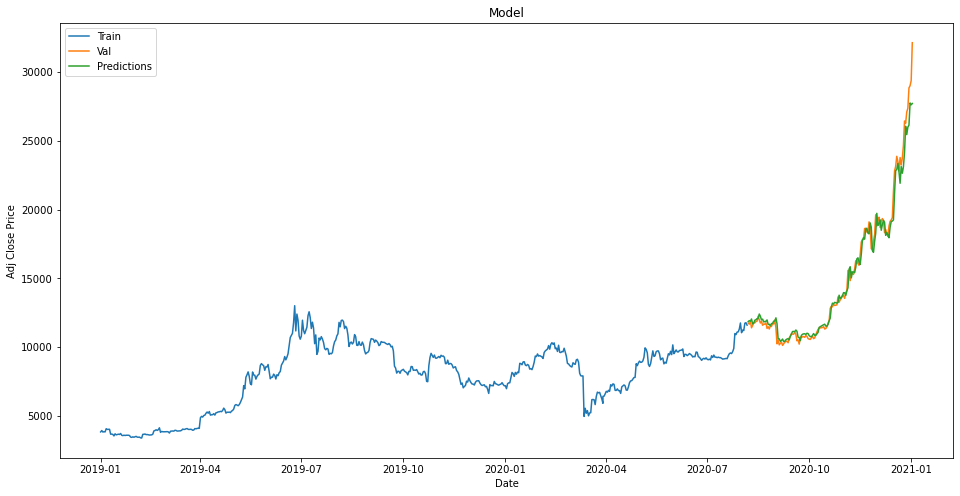

In [21]:
#Plot the data
train = bitcoin[: training_len]
valid = bitcoin[training_len:]
valid["Predictions"] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title("Model")
plt.xlabel("Date")
plt.ylabel("Adj Close Price")
plt.plot(train["Adj Close"])
plt.plot(valid[["Adj Close", "Predictions"]])
plt.legend(["Train", "Val", "Predictions"])

In [22]:
valid["difference"] = (abs(valid["Adj Close"] - valid["Predictions"])) / valid["Adj Close"]

C:\Users\Han\.conda\envs\python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
valid

,Adj Close,Predictions,difference
Date,,,
2020-08-07,11754.045898,11858.306641,0.008870
2020-08-08,11675.739258,11929.883789,0.021767
2020-08-09,11878.111328,11887.667969,0.000805
2020-08-10,11410.525391,12049.268555,0.055978
2020-08-11,11584.934570,11690.786133,0.009137
...,...,...,...
2020-12-29,27362.437500,25992.285156,0.050074
2020-12-30,28840.953125,26139.236328,0.093676
2020-12-31,29001.720703,27747.257812,0.043255
